# Run to Failure degradation simulation of NASA Turbo Jet Engine Fans

# <a id='index'>Index</a>

+ <a href='#data_analysis'>1. Data Analysis</a>
    + <a href='#info_about_data'>1.1 Info about data:</a>
+ <a href='#noise_removal'>2. Noise removal and Normalization</a>
+ <a href='#training_and_validation'>3. Training and Validation</a>
+ <a href='#testing'>4 Testing</a>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import math
import matplotlib.pyplot as plt
from matplotlib import cm

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import QuantileTransformer , PowerTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

# from keras import optimizers
# from keras.models import Sequential
# from keras.layers import TimeDistributed, Flatten
# from keras.layers.core import Dense, Dropout, Activation
# from keras.layers.recurrent import LSTM
from sklearn.metrics import mean_squared_error

import warnings 
#warnings.filterwarnings('ignore')

%matplotlib inline
cmap = cm.get_cmap('Spectral') # Colour map (there are many others)

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score
from sklearn.metrics import r2_score

# from keras.models import load_model

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchsummary import summary

from tqdm import tqdm

C:\Users\CallO\AppData\Local\Temp\ipykernel_26144\2410309670.py:31: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('Spectral') # Colour map (there are many others)


# <a id='data_analysis'>1. Data analysis</a>
<a href='#index'>Go back to Index</a>

In [2]:
train_file = "train_FD001.txt" 
test_file = "test_FD001.txt"
RUL_file = "RUL_FD001.txt"

df = pd.read_csv(train_file,sep=" ",header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,NaN,NaN
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,NaN,NaN
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,NaN,NaN
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,NaN,NaN
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,NaN,NaN


In [3]:
#columns = ['unit_number','time_in_cycles','setting_1','setting_2','TRA','T2','T24','T30','T50','P2','P15','P30','Nf',
#           'Nc','epr','Ps3 0','phi','NRf','NRc','BPR','farB','htBleed','Nf_dmd','PCNfR_dmd','W31','W32' ]
#delete NaN values
df.drop(columns=[26,27],inplace=True)
columns = ["Section-{}".format(i)  for i in range(26)]
df.columns = columns
df.head()

,Section-0,Section-1,Section-2,Section-3,Section-4,Section-5,Section-6,Section-7,Section-8,Section-9,...,Section-16,Section-17,Section-18,Section-19,Section-20,Section-21,Section-22,Section-23,Section-24,Section-25
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


#### Dataset statistics  for each parameter

In [4]:
df.describe()

,Section-0,Section-1,Section-2,Section-3,Section-4,Section-5,Section-6,Section-7,Section-8,Section-9,...,Section-16,Section-17,Section-18,Section-19,Section-20,Section-21,Section-22,Section-23,Section-24,Section-25
count,20631.000000,20631.000000,20631.000000,20631.000000,20631.0,2.063100e+04,20631.000000,20631.000000,20631.000000,2.063100e+04,...,20631.000000,20631.000000,20631.000000,20631.000000,2.063100e+04,20631.000000,20631.0,20631.0,20631.000000,20631.000000
mean,51.506568,108.807862,-0.000009,0.000002,100.0,5.186700e+02,642.680934,1590.523119,1408.933782,1.462000e+01,...,521.413470,2388.096152,8143.752722,8.442146,3.000000e-02,393.210654,2388.0,100.0,38.816271,23.289705
std,29.227633,68.880990,0.002187,0.000293,0.0,6.537152e-11,0.500053,6.131150,9.000605,3.394700e-12,...,0.737553,0.071919,19.076176,0.037505,1.556432e-14,1.548763,0.0,0.0,0.180746,0.108251
min,1.000000,1.000000,-0.008700,-0.000600,100.0,5.186700e+02,641.210000,1571.040000,1382.250000,1.462000e+01,...,518.690000,2387.880000,8099.940000,8.324900,3.000000e-02,388.000000,2388.0,100.0,38.140000,22.894200
25%,26.000000,52.000000,-0.001500,-0.000200,100.0,5.186700e+02,642.325000,1586.260000,1402.360000,1.462000e+01,...,520.960000,2388.040000,8133.245000,8.414900,3.000000e-02,392.000000,2388.0,100.0,38.700000,23.221800
50%,52.000000,104.000000,0.000000,0.000000,100.0,5.186700e+02,642.640000,1590.100000,1408.040000,1.462000e+01,...,521.480000,2388.090000,8140.540000,8.438900,3.000000e-02,393.000000,2388.0,100.0,38.830000,23.297900
75%,77.000000,156.000000,0.001500,0.000300,100.0,5.186700e+02,643.000000,1594.380000,1414.555000,1.462000e+01,...,521.950000,2388.140000,8148.310000,8.465600,3.000000e-02,394.000000,2388.0,100.0,38.950000,23.366800
max,100.000000,362.000000,0.008700,0.000600,100.0,5.186700e+02,644.530000,1616.910000,1441.490000,1.462000e+01,...,523.380000,2388.560000,8293.720000,8.584800,3.000000e-02,400.000000,2388.0,100.0,39.430000,23.618400


## <a id='info_about_data'>1.1 Info about data:</a>
- Section-0 is MachineID
- Section-1 is time in, Cycles
- Section-2...4 is Opertional Settings
- Section-5...25 is sensor's data 


- Data Set: FD001
- Train trjectories: 100
- Test trajectories: 100
- Conditions: ONE (Sea Level)
- Fault Modes: ONE (HPC Degradation)

In [5]:
# Names 
MachineID_name = ["Section-0"]
RUL_name = ["Section-1"]
OS_name = ["Section-{}".format(i) for i in range(2,5)]
Sensor_name = ["Section-{}".format(i) for i in range(5,26)]

# Data in pandas DataFrame
MachineID_data = df[MachineID_name]
RUL_data = df[RUL_name]
OS_data = df[OS_name]
Sensor_data = df[Sensor_name]

# Data in pandas Series
MachineID_series = df["Section-0"]
RUL_series = df["Section-1"]

In [6]:
grp = RUL_data.groupby(MachineID_series)
max_cycles = np.array([max(grp.get_group(i)["Section-1"]) for i in MachineID_series.unique()])
print("Max Life >> ",max(max_cycles))
print("Mean Life >> ",np.mean(max_cycles))
print("Min Life >> ",min(max_cycles))

Max Life >>  362
Mean Life >>  206.31
Min Life >>  128


From the above vizulization its clear that 
- Section-4 (Oprational Setting-3)
- Section-5 (Sensor-1)
- Section-9  (Sensor-5)
- Section-14 (Sensor-10)
- Section-20 (Sensor-16)
- Section-22 (Sensor-18)
- Section-23 (Sensor-19)

Does not play a vital role in variation of data and there std is also almost 0 so, these sensor data is useless for us hence, we can drop this coloumn data

In [7]:
#delete columns with constant values that do not carry information about the state of the unit
#data = pd.concat([RUL_data,OS_data,Sensor_data], axis=1)
df.drop(columns=["Section-0",
                "Section-4", # Operatinal Setting
                "Section-5", # Sensor data
                "Section-9", # Sensor data
                "Section-10", # Sensor data
                "Section-14",# Sensor data
                "Section-20",# Sensor data
                "Section-22",# Sensor data
                "Section-23"] , inplace=True)

In [8]:
df.head()

,Section-1,Section-2,Section-3,Section-6,Section-7,Section-8,Section-11,Section-12,Section-13,Section-15,Section-16,Section-17,Section-18,Section-19,Section-21,Section-24,Section-25
0,1,-0.0007,-0.0004,641.82,1589.70,1400.60,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190
1,2,0.0019,-0.0003,642.15,1591.82,1403.14,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236
2,3,-0.0043,0.0003,642.35,1587.99,1404.20,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442
3,4,0.0007,0.0000,642.35,1582.79,1401.87,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739
4,5,-0.0019,-0.0002,642.37,1582.85,1406.22,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044


# <a id='noise_removal'>2. Noise removal and Normalization</a>
<a href='#index'>Go back to Index</a>

In [9]:
print(type(df))
gen = MinMaxScaler(feature_range=(0, 1))
df = gen.fit_transform(df)
df = pd.DataFrame(df)
#df = df.rolling(20).mean()
# pt = PowerTransformer()
# df = pt.fit_transform(df)

<class 'pandas.core.frame.DataFrame'>


In [10]:
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,0.000000,0.459770,0.166667,0.183735,0.406802,0.309757,0.726248,0.242424,0.109755,0.369048,0.633262,0.205882,0.199608,0.363986,0.333333,0.713178,0.724662
1,0.002770,0.609195,0.250000,0.283133,0.453019,0.352633,0.628019,0.212121,0.100242,0.380952,0.765458,0.279412,0.162813,0.411312,0.333333,0.666667,0.731014
2,0.005540,0.252874,0.750000,0.343373,0.369523,0.370527,0.710145,0.272727,0.140043,0.250000,0.795309,0.220588,0.171793,0.357445,0.166667,0.627907,0.621375
3,0.008310,0.540230,0.500000,0.343373,0.256159,0.331195,0.740741,0.318182,0.124518,0.166667,0.889126,0.294118,0.174889,0.166603,0.333333,0.573643,0.662386
4,0.011080,0.390805,0.333333,0.349398,0.257467,0.404625,0.668277,0.242424,0.149960,0.255952,0.746269,0.235294,0.174734,0.402078,0.416667,0.589147,0.704502
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,0.540166,0.477011,0.250000,0.686747,0.587312,0.782917,0.254428,0.439394,0.196491,0.726190,0.170576,0.558824,0.194344,0.656791,0.750000,0.271318,0.109500
20627,0.542936,0.408046,0.083333,0.701807,0.729453,0.866475,0.162641,0.500000,0.194651,0.708333,0.211087,0.500000,0.188668,0.727203,0.583333,0.124031,0.366197
20628,0.545706,0.522989,0.500000,0.665663,0.684979,0.775321,0.175523,0.515152,0.198196,0.738095,0.281450,0.529412,0.212148,0.922278,0.833333,0.232558,0.053991
20629,0.548476,0.436782,0.750000,0.608434,0.746021,0.747468,0.133655,0.530303,0.233285,0.916667,0.208955,0.514706,0.203065,0.823394,0.583333,0.116279,0.234466


In [11]:
df=np.nan_to_num(df)

In [12]:
df

array([[0.        , 0.45977011, 0.16666667, ..., 0.33333333, 0.71317829,
        0.7246617 ],
       [0.00277008, 0.6091954 , 0.25      , ..., 0.33333333, 0.66666667,
        0.73101353],
       [0.00554017, 0.25287356, 0.75      , ..., 0.16666667, 0.62790698,
        0.62137531],
       ...,
       [0.54570637, 0.52298851, 0.5       , ..., 0.83333333, 0.23255814,
        0.05399061],
       [0.54847645, 0.43678161, 0.75      , ..., 0.58333333, 0.11627907,
        0.23446562],
       [0.55124654, 0.31609195, 0.08333333, ..., 0.66666667, 0.17829457,
        0.21817178]])

In [13]:
# grouping w.r.t MID (Machine ID)
# col_names = df.columns
# def grouping(datafile, mid_series):
#     data = [x for x in datafile.groupby(mid_series)]
#     return data 

# <a id='training_and_validation'>3. Training and Validation using LSTM</a>
<a href='#index'>Go back to Index</a>

In [14]:
def RUL_df():
    rul_lst = [j  for i in MachineID_series.unique() for j in np.array(grp.get_group(i)[::-1]["Section-1"])]
    rul_col = pd.DataFrame({"rul":rul_lst})
    return rul_col

RUL_df().head()

,rul
0,192
1,191
2,190
3,189
4,188


In [15]:
X_train = np.array(df)

y_train = np.array(RUL_df()).reshape(-1,1).clip(max=135)

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20) 


print(X_train.shape,y_train.shape)

(20631, 17) (20631, 1)


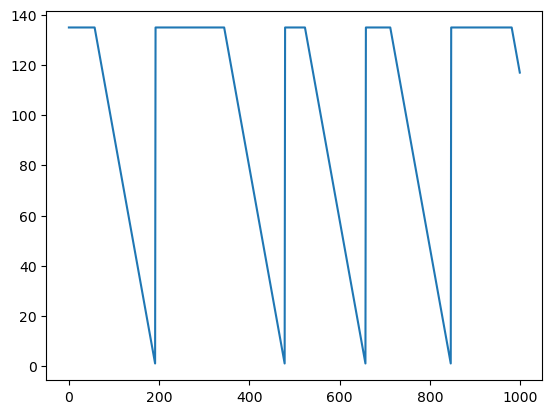

In [16]:
plt.plot(y_train[:1000])

In [17]:
max_cycles

array([192, 287, 179, 189, 269, 188, 259, 150, 201, 222, 240, 170, 163,
       180, 207, 209, 276, 195, 158, 234, 195, 202, 168, 147, 230, 199,
       156, 165, 163, 194, 234, 191, 200, 195, 181, 158, 170, 194, 128,
       188, 216, 196, 207, 192, 158, 256, 214, 231, 215, 198, 213, 213,
       195, 257, 193, 275, 137, 147, 231, 172, 185, 180, 174, 283, 153,
       202, 313, 199, 362, 137, 208, 213, 213, 166, 229, 210, 154, 231,
       199, 185, 240, 214, 293, 267, 188, 278, 178, 213, 217, 154, 135,
       341, 155, 258, 283, 336, 202, 156, 185, 200])

In [18]:
max_cycles[5]

188

In [19]:
# window_size = 20

# X_time = []
# y_time = []

# for i in range(100):
#     i_idx = grp.get_group(i+1).values.reshape(-1)

#     for j in range(len(i_idx)-window_size):
#         X_time.append(X_train[i_idx[0]+j:i_idx[0]+j+window_size])

#     y_time.append(y_train[i_idx[0]+window_size:i_idx[-1]+1])


# X_train = np.array(X_time)
# y_train = np.concatenate(y_time, axis=0).reshape(-1)

In [20]:
print(max_cycles)
print(sum(max_cycles))
count = 0
for cycle_len in max_cycles:
    for i in range(21):
        y_train[count+i] = 0
    count = count + cycle_len
print(count)

[192 287 179 189 269 188 259 150 201 222 240 170 163 180 207 209 276 195
 158 234 195 202 168 147 230 199 156 165 163 194 234 191 200 195 181 158
 170 194 128 188 216 196 207 192 158 256 214 231 215 198 213 213 195 257
 193 275 137 147 231 172 185 180 174 283 153 202 313 199 362 137 208 213
 213 166 229 210 154 231 199 185 240 214 293 267 188 278 178 213 217 154
 135 341 155 258 283 336 202 156 185 200]
20631
20631


In [21]:
def create_dataset(X, look_back=20):
    data = []
    for i in range(len(X)-look_back-1):
        data.append(X[i:(i+look_back)])
    return np.array(data)


X_train = create_dataset(X_train)
y_train = y_train[21:]

In [22]:
print(X_train.shape,y_train.shape)

(20610, 20, 17) (20610, 1)


In [23]:
print(y_train)

[[135]
 [135]
 [135]
 ...
 [  3]
 [  2]
 [  1]]


In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)

In [25]:
class Autoencoder(nn.Module):
    def __init__(self, feature_size):
        super(Autoencoder, self).__init__()
        
        self.encoder1 = nn.Linear(20*17, 128)
        self.encoder2 = nn.Linear(128, 64)
        self.decoder1 = nn.Linear(64, 128)
        self.decoder2 = nn.Linear(128, 20*17)
        
        self.lstm1 = nn.LSTM(input_size=feature_size, hidden_size=128, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=128, hidden_size=64, batch_first=True)
        
        self.fc1 = nn.Linear(64, 16)
        self.fc2 = nn.Linear(16, 1)
        
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.flatten(start_dim=1)
        
        x = nn.ReLU()(self.encoder1(x))
        x = nn.ReLU()(self.encoder2(x))
        x = nn.ReLU()(self.decoder1(x))
        x = self.decoder2(x)
        
        x_rec = x.reshape(-1, 20, 17)
        x = x_rec
   
        # LSTM layers
        out, _ = self.lstm1(x)
        out, _ = self.lstm2(out)
        
        # Dense layers
        out = self.relu(self.fc1(out[:, -1, :]))  # Take the output of the last time step
        out = self.fc2(out)
        
        return out, x_rec

# Model instantiation
def build_model(layers):
    model = Autoencoder(layers)
    return model

# Loss and optimizer
model = build_model(X_train.shape[-1]).to(device)  # Example input size (replace with actual layer sizes)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.1)

In [26]:
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)

In [27]:
epochs = 75
for epoch in tqdm(range(epochs)):
    model.train()  
    running_loss = 0.0

    for batch_idx, (inputs, targets) in enumerate(train_loader):
        
        inputs, targets = inputs.to(device), targets.to(device)

        
        outputs, inputs_rec = model(inputs)
        loss = loss_fn(outputs, targets) + 0.5 * loss_fn(inputs, inputs_rec)

        
        optimizer.zero_grad()  
        loss.backward()  
        optimizer.step()  

        
        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")

  1%|▏         | 1/75 [00:03<04:06,  3.33s/it]

Epoch [1/75], Loss: 8409.4662


  3%|▎         | 2/75 [00:07<04:22,  3.59s/it]

Epoch [2/75], Loss: 8017.1546


  4%|▍         | 3/75 [00:11<04:42,  3.92s/it]

Epoch [3/75], Loss: 7356.0295


  5%|▌         | 4/75 [00:15<04:29,  3.80s/it]

Epoch [4/75], Loss: 6715.3614


  7%|▋         | 5/75 [00:18<04:14,  3.64s/it]

Epoch [5/75], Loss: 5987.8035


  8%|▊         | 6/75 [00:21<04:08,  3.60s/it]

Epoch [6/75], Loss: 5103.5550


  9%|▉         | 7/75 [00:25<04:01,  3.56s/it]

Epoch [7/75], Loss: 4352.3590


 11%|█         | 8/75 [00:28<03:54,  3.49s/it]

Epoch [8/75], Loss: 3664.4511


 12%|█▏        | 9/75 [00:32<03:54,  3.56s/it]

Epoch [9/75], Loss: 3155.6865


 13%|█▎        | 10/75 [00:36<03:51,  3.56s/it]

Epoch [10/75], Loss: 2809.2823


 15%|█▍        | 11/75 [00:39<03:53,  3.65s/it]

Epoch [11/75], Loss: 2617.3550


 16%|█▌        | 12/75 [00:43<03:46,  3.59s/it]

Epoch [12/75], Loss: 2531.4122


 17%|█▋        | 13/75 [00:46<03:38,  3.53s/it]

Epoch [13/75], Loss: 2482.7305


 19%|█▊        | 14/75 [00:50<03:34,  3.51s/it]

Epoch [14/75], Loss: 2099.3506


 20%|██        | 15/75 [00:53<03:34,  3.58s/it]

Epoch [15/75], Loss: 1300.7373


 21%|██▏       | 16/75 [00:57<03:25,  3.49s/it]

Epoch [16/75], Loss: 970.3624


 23%|██▎       | 17/75 [01:00<03:16,  3.38s/it]

Epoch [17/75], Loss: 780.8324


 24%|██▍       | 18/75 [01:03<03:09,  3.32s/it]

Epoch [18/75], Loss: 670.4818


 25%|██▌       | 19/75 [01:06<03:04,  3.29s/it]

Epoch [19/75], Loss: 601.6319


 27%|██▋       | 20/75 [01:10<03:02,  3.32s/it]

Epoch [20/75], Loss: 517.9258


 28%|██▊       | 21/75 [01:13<02:58,  3.31s/it]

Epoch [21/75], Loss: 453.3651


 29%|██▉       | 22/75 [01:16<02:54,  3.29s/it]

Epoch [22/75], Loss: 419.3333


 31%|███       | 23/75 [01:19<02:50,  3.28s/it]

Epoch [23/75], Loss: 397.0715


 32%|███▏      | 24/75 [01:23<02:46,  3.27s/it]

Epoch [24/75], Loss: 394.2517


 33%|███▎      | 25/75 [01:26<02:43,  3.27s/it]

Epoch [25/75], Loss: 370.2525


 35%|███▍      | 26/75 [01:29<02:43,  3.34s/it]

Epoch [26/75], Loss: 366.8390


 36%|███▌      | 27/75 [01:33<02:43,  3.41s/it]

Epoch [27/75], Loss: 369.7027


 37%|███▋      | 28/75 [01:36<02:39,  3.39s/it]

Epoch [28/75], Loss: 332.8168


 39%|███▊      | 29/75 [01:40<02:35,  3.39s/it]

Epoch [29/75], Loss: 320.0964


 40%|████      | 30/75 [01:43<02:31,  3.38s/it]

Epoch [30/75], Loss: 324.9975


 41%|████▏     | 31/75 [01:47<02:31,  3.44s/it]

Epoch [31/75], Loss: 319.9851


 43%|████▎     | 32/75 [01:50<02:26,  3.41s/it]

Epoch [32/75], Loss: 304.3287


 44%|████▍     | 33/75 [01:53<02:23,  3.41s/it]

Epoch [33/75], Loss: 309.3724


 45%|████▌     | 34/75 [01:57<02:26,  3.58s/it]

Epoch [34/75], Loss: 291.7703


 47%|████▋     | 35/75 [02:01<02:21,  3.54s/it]

Epoch [35/75], Loss: 278.7464


 48%|████▊     | 36/75 [02:04<02:18,  3.54s/it]

Epoch [36/75], Loss: 254.4729


 49%|████▉     | 37/75 [02:08<02:17,  3.61s/it]

Epoch [37/75], Loss: 262.9590


 51%|█████     | 38/75 [02:12<02:12,  3.59s/it]

Epoch [38/75], Loss: 254.0419


 52%|█████▏    | 39/75 [02:15<02:09,  3.60s/it]

Epoch [39/75], Loss: 252.0798


 53%|█████▎    | 40/75 [02:19<02:08,  3.66s/it]

Epoch [40/75], Loss: 252.6221


 55%|█████▍    | 41/75 [02:22<01:59,  3.51s/it]

Epoch [41/75], Loss: 240.0926


 56%|█████▌    | 42/75 [02:26<01:54,  3.46s/it]

Epoch [42/75], Loss: 249.2024


 57%|█████▋    | 43/75 [02:29<01:48,  3.38s/it]

Epoch [43/75], Loss: 236.8285


 59%|█████▊    | 44/75 [02:32<01:44,  3.38s/it]

Epoch [44/75], Loss: 232.5272


 60%|██████    | 45/75 [02:35<01:39,  3.32s/it]

Epoch [45/75], Loss: 235.1006


 61%|██████▏   | 46/75 [02:38<01:34,  3.27s/it]

Epoch [46/75], Loss: 229.3239


 63%|██████▎   | 47/75 [02:42<01:32,  3.29s/it]

Epoch [47/75], Loss: 232.1044


 64%|██████▍   | 48/75 [02:45<01:30,  3.36s/it]

Epoch [48/75], Loss: 228.4523


 65%|██████▌   | 49/75 [02:48<01:25,  3.28s/it]

Epoch [49/75], Loss: 263.3758


 67%|██████▋   | 50/75 [02:52<01:21,  3.24s/it]

Epoch [50/75], Loss: 225.7951


 68%|██████▊   | 51/75 [02:55<01:17,  3.23s/it]

Epoch [51/75], Loss: 223.1307


 69%|██████▉   | 52/75 [02:58<01:13,  3.21s/it]

Epoch [52/75], Loss: 220.2420


 71%|███████   | 53/75 [03:02<01:14,  3.36s/it]

Epoch [53/75], Loss: 219.5174


 72%|███████▏  | 54/75 [03:05<01:12,  3.47s/it]

Epoch [54/75], Loss: 217.5402


 73%|███████▎  | 55/75 [03:09<01:09,  3.45s/it]

Epoch [55/75], Loss: 216.9746


 75%|███████▍  | 56/75 [03:12<01:03,  3.36s/it]

Epoch [56/75], Loss: 213.9518


 76%|███████▌  | 57/75 [03:15<01:00,  3.38s/it]

Epoch [57/75], Loss: 227.5368


 77%|███████▋  | 58/75 [03:19<00:59,  3.52s/it]

Epoch [58/75], Loss: 227.3562


 79%|███████▊  | 59/75 [03:22<00:54,  3.41s/it]

Epoch [59/75], Loss: 233.4353


 80%|████████  | 60/75 [03:26<00:51,  3.47s/it]

Epoch [60/75], Loss: 217.3182


 81%|████████▏ | 61/75 [03:30<00:48,  3.50s/it]

Epoch [61/75], Loss: 224.4507


 83%|████████▎ | 62/75 [03:33<00:46,  3.55s/it]

Epoch [62/75], Loss: 227.2680


 84%|████████▍ | 63/75 [03:37<00:41,  3.47s/it]

Epoch [63/75], Loss: 208.8893


 85%|████████▌ | 64/75 [03:40<00:37,  3.42s/it]

Epoch [64/75], Loss: 207.5854


 87%|████████▋ | 65/75 [03:43<00:33,  3.34s/it]

Epoch [65/75], Loss: 205.3606


 88%|████████▊ | 66/75 [03:46<00:30,  3.33s/it]

Epoch [66/75], Loss: 206.8226


 89%|████████▉ | 67/75 [03:49<00:26,  3.26s/it]

Epoch [67/75], Loss: 207.3260


 91%|█████████ | 68/75 [03:53<00:22,  3.25s/it]

Epoch [68/75], Loss: 212.3547


 92%|█████████▏| 69/75 [03:56<00:19,  3.31s/it]

Epoch [69/75], Loss: 229.6308


 93%|█████████▎| 70/75 [04:00<00:17,  3.40s/it]

Epoch [70/75], Loss: 236.3833


 95%|█████████▍| 71/75 [04:03<00:13,  3.38s/it]

Epoch [71/75], Loss: 211.2993


 96%|█████████▌| 72/75 [04:06<00:10,  3.40s/it]

Epoch [72/75], Loss: 204.0228


 97%|█████████▋| 73/75 [04:10<00:06,  3.46s/it]

Epoch [73/75], Loss: 203.4426


 99%|█████████▊| 74/75 [04:14<00:03,  3.64s/it]

Epoch [74/75], Loss: 198.8326


100%|██████████| 75/75 [04:18<00:00,  3.44s/it]

Epoch [75/75], Loss: 194.7459


In [28]:
model(X_train.to(device))[0]

tensor([[133.6207],
        [133.5795],
        [133.3969],
        ...,
        [  3.6096],
        [  3.4270],
        [  2.9482]], grad_fn=<AddmmBackward0>)

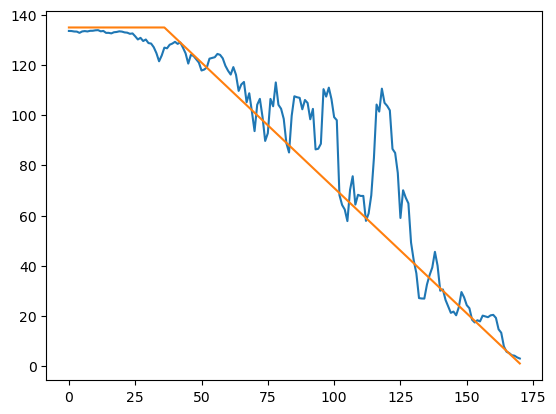

In [29]:
pred = model(X_train[:171].to(device))[0].detach().cpu().numpy()
plt.plot(pred)
plt.plot(y_train[:171].reshape(-1).numpy())

In [30]:
y_train_pred = model(X_train.to(device))[0].detach().cpu()
print("mean_squared_error >> ", mean_squared_error(y_train,y_train_pred))
print("root_mean_squared_error >> ", math.sqrt(mean_squared_error(y_train,y_train_pred)))
print("mean_absolute_error >>",mean_absolute_error(y_train,y_train_pred))

mean_squared_error >>  193.18059
root_mean_squared_error >>  13.898941965795622
mean_absolute_error >> 9.291899


# <a id='testing'>4 Testing</a>
<a href='#index'>Go back to Index</a>

In [31]:
df_test = pd.read_csv(test_file, sep=" ",header=None)
df_test.drop(columns=[26,27],inplace=True)
df_test.columns = columns
df_test.head()

,Section-0,Section-1,Section-2,Section-3,Section-4,Section-5,Section-6,Section-7,Section-8,Section-9,...,Section-16,Section-17,Section-18,Section-19,Section-20,Section-21,Section-22,Section-23,Section-24,Section-25
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130


In [32]:
df_rul = pd.read_csv(RUL_file, names=['rul'])
df_rul.head()

,rul
0,112
1,98
2,69
3,82
4,91


In [33]:
RUL_name = ["Section-1"]
RUL_data = df_test[RUL_name]
MachineID_series = df_test["Section-0"]
grp = RUL_data.groupby(MachineID_series)
max_cycles = np.array([max(grp.get_group(i)["Section-1"]) for i in MachineID_series.unique()])
max_cycles[0] = max_cycles[0] - 21

In [34]:
df_test.drop(df_test[["Section-0",
                "Section-4", # Operatinal Setting
                "Section-5", # Sensor data
                "Section-9", # Sensor data
                "Section-10", # Sensor data
                "Section-14",# Sensor data
                "Section-20",# Sensor data
                "Section-22",# Sensor data
                "Section-23"]], axis=1 , inplace=True)
#df_test = df_test.groupby(["Section-0"])
#print(df_test)


In [35]:
gen = MinMaxScaler(feature_range=(0, 1))
df_test = gen.fit_transform(df_test)
df_test = pd.DataFrame(df_test)
#df_test = df_test.rolling(20).mean()
# pt = PowerTransformer()
# df_test = pt.fit_transform(df_test)
# df_test=np.nan_to_num(df_test)

In [36]:
df_test

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,0.000000,0.65625,0.692308,0.596215,0.421968,0.282214,0.608871,0.365854,0.196475,0.273973,0.534247,0.325581,0.152259,0.347076,0.375,0.500000,0.620099
1,0.003311,0.34375,0.230769,0.182965,0.504025,0.225240,0.800403,0.292683,0.229042,0.479452,0.634703,0.395349,0.277907,0.227709,0.500,0.645455,0.645718
2,0.006623,0.53125,0.538462,0.419558,0.464814,0.346130,0.651210,0.390244,0.248506,0.479452,0.591324,0.325581,0.192892,0.533557,0.500,0.700000,0.681104
3,0.009934,0.77500,0.461538,0.413249,0.391587,0.449867,0.643145,0.341463,0.159080,0.328767,0.456621,0.372093,0.217896,0.282359,0.250,0.627273,0.620382
4,0.013245,0.60000,0.461538,0.435331,0.471306,0.357974,0.661290,0.292683,0.153410,0.349315,0.632420,0.325581,0.187891,0.337009,0.125,0.618182,0.676008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13091,0.639073,0.81875,0.461538,0.665615,0.789665,0.641209,0.510081,0.317073,0.902989,0.609589,0.299087,0.255814,0.935703,0.664909,0.625,0.309091,0.370842
13092,0.642384,0.44375,0.384615,0.659306,0.692028,0.769042,0.471774,0.390244,0.890038,0.547945,0.381279,0.465116,0.914003,0.567593,0.750,0.236364,0.483652
13093,0.645695,0.47500,0.230769,0.728707,0.626071,0.458036,0.435484,0.536585,0.937011,0.527397,0.410959,0.348837,0.971066,0.594919,0.750,0.281818,0.381741
13094,0.649007,0.27500,0.538462,0.671924,0.673851,0.714111,0.502016,0.439024,0.952644,0.554795,0.445205,0.441860,1.000000,0.662991,0.750,0.318182,0.473461


In [37]:
X_test = np.array(df_test)

y_test = np.array(df_rul)



# X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
# X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_test.shape,y_test.shape)
print(max_cycles)

(13096, 17) (100, 1)
[ 10  49 126 106  98 105 160 166  55 192  83 217 195  46  76 113 165 133
 135 184 148  39 130 186  48  76 140 158 171 143 196 145  50 203 198 126
 121 125  37 133 123 156 172  54 152 146  73  78 303  74 144 189 164 121
 113 136 160 176  94 147 159 232 155 168  71 147  71 187  54 152  68 131
 112 137  88 205 162  72 101 133 213 162  73 172  34 110  56  68 177 146
 234 150 244 133  89  97 134 121  97 198]


In [38]:
def create_dataset(X, look_back=20):
    data = []
    for i in range(len(X)-look_back-1):
        data.append(X[i:(i+look_back)])
    return np.array(data)

In [39]:
X_test = create_dataset(X_test)
#y_test = y_test[6:]

In [40]:
print(X_test.shape,y_test.shape)

(13075, 20, 17) (100, 1)


In [41]:
X_test.shape

(13075, 20, 17)

In [42]:
pred = model(torch.tensor(X_test, dtype=torch.float32).to(device))[0].detach().cpu()

In [43]:
pred.shape

torch.Size([13075, 1])

In [44]:
final_pred = []
count = 0
for i in range(100):
    temp = 0
    j = max_cycles[i] 
    while j>0:
        temp = temp + pred[count]
        j=j-1
        count=count+1
    final_pred.append(int(temp/max_cycles[i]))

In [45]:
print(final_pred)

[131, 111, 75, 82, 83, 92, 94, 90, 68, 86, 41, 96, 76, 46, 114, 114, 41, 46, 89, 48, 85, 69, 120, 52, 73, 93, 100, 100, 88, 76, 39, 43, 44, 60, 46, 20, 69, 36, 57, 38, 70, 70, 85, 88, 69, 41, 36, 99, 79, 66, 102, 86, 67, 90, 100, 24, 85, 82, 91, 89, 51, 88, 78, 65, 50, 45, 74, 71, 79, 106, 63, 64, 101, 77, 84, 70, 75, 78, 98, 67, 35, 43, 83, 84, 50, 95, 84, 62, 96, 73, 38, 33, 49, 63, 95, 73, 53, 65, 86, 70]


In [46]:
final_pred[0]

131

## Using last index as prediction

In [47]:
def scoring_function(actual,predicted):
    d = []
    for i in range(len(predicted)):
        d.append((predicted[i] - actual[i]))
    scores = []
    for i in range(len(d)):
        if d[i] >= 0:
            scores.append(math.exp(d[i]/10) - 1)
        else :
            scores.append(math.exp((-1*d[i])/13) - 1)
    return sum(scores)

[130, 110, 21, 54, 48, 56, 78, 53, 65, 58, 20, 67, 67, 38, 82, 87, 16, 15, 60, 1, 37, 127, 108, 2, 120, 51, 81, 82, 55, 65, 0, 19, 38, 0, 0, 0, 8, 12, 128, 0, 9, 2, 33, 124, 27, 13, 28, 75, 2, 47, 66, 13, 8, 77, 97, 0, 68, 25, 82, 81, 7, 35, 49, 5, 65, 0, 84, 0, 128, 70, 45, 38, 96, 56, 55, 0, 15, 98, 87, 48, 0, 1, 104, 40, 115, 45, 84, 28, 67, 7, 1, 0, 7, 23, 98, 51, 38, 39, 59, 1]


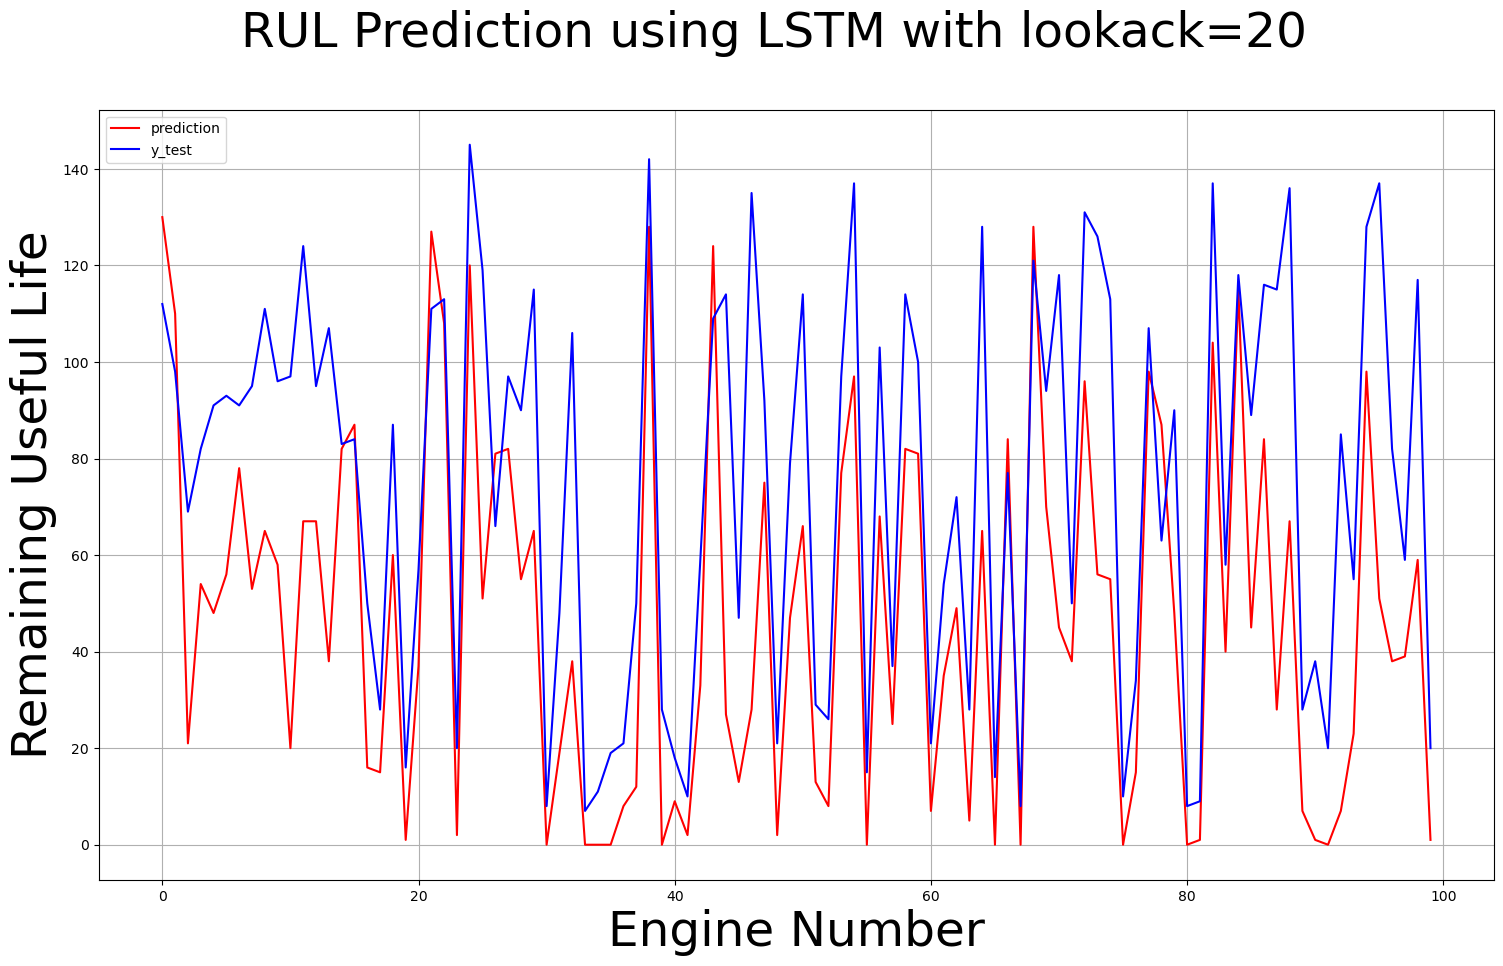

mean_squared_error >>  1439.95
root_mean_squared_error >>  37.94667310845577
mean_absolute_error >> 30.61
scoring function >> 9213.086432683003


C:\Users\CallO\AppData\Local\Temp\ipykernel_26144\1752460767.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  scores.append(math.exp(d[i]/10) - 1)
C:\Users\CallO\AppData\Local\Temp\ipykernel_26144\1752460767.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  scores.append(math.exp((-1*d[i])/13) - 1)


In [48]:
final_pred = []
count = 0
for i in range(100):
    j = max_cycles[i] 
    temp = pred[count+j-1]
    count=count+j
    final_pred.append(int(temp))

print(final_pred)


fig = plt.figure(figsize=(18,10))
plt.plot(final_pred,color='red', label='prediction')
plt.plot(y_test,color='blue', label='y_test')

fig.suptitle('RUL Prediction using LSTM with lookack=20', fontsize=35)
plt.xlabel("Engine Number", fontsize=35)
plt.ylabel("Remaining Useful Life", fontsize=35)

plt.legend(loc='upper left')
plt.grid()
plt.show()

print("mean_squared_error >> ", mean_squared_error(y_test,final_pred))
print("root_mean_squared_error >> ", math.sqrt(mean_squared_error(y_test,final_pred)))
print("mean_absolute_error >>",mean_absolute_error(y_test,final_pred))
print("scoring function >>",scoring_function(y_test,final_pred))

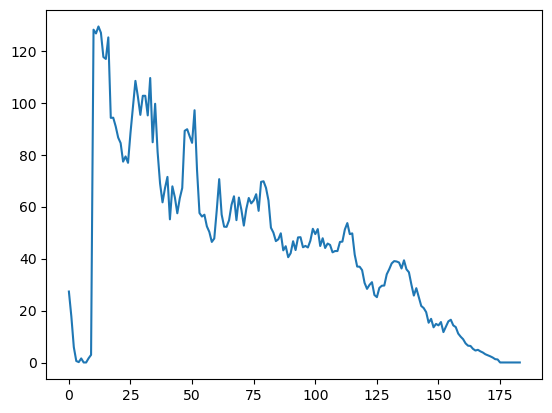

In [49]:
show_idx = grp.get_group(20).index - 10
plt.plot(pred[show_idx])

In [50]:
np.where(np.isclose(final_pred, 0))

(array([30, 33, 34, 35, 39, 55, 65, 67, 75, 80, 91], dtype=int64),)

In [51]:
np.where(max_cycles.reshape(-1)>df_rul.values.reshape(-1))

(array([ 2,  3,  4,  5,  6,  7,  9, 11, 12, 15, 16, 17, 18, 19, 20, 22, 23,
        26, 27, 28, 29, 30, 31, 33, 34, 35, 36, 37, 39, 40, 41, 42, 44, 45,
        48, 50, 51, 52, 53, 55, 56, 57, 59, 60, 61, 62, 63, 65, 67, 69, 71,
        73, 75, 76, 78, 79, 80, 81, 83, 85, 88, 89, 90, 91, 92, 93, 96, 97,
        99], dtype=int64),)

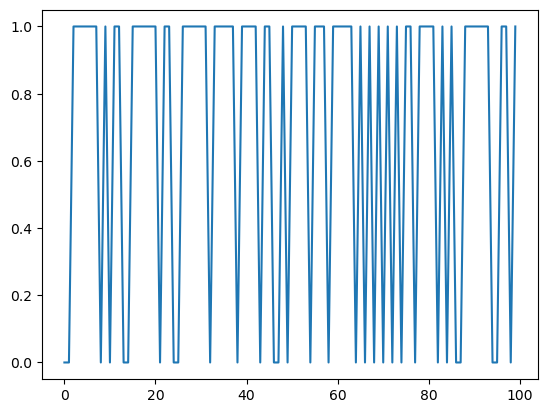

In [52]:
plt.plot(max_cycles.reshape(-1)>df_rul.values.reshape(-1))